# This script is inspired by [Deneil Weitzenfeld's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) blog. 
## I am interested in implementing the same hierarchical Bayesian model to NBA. The first attribution to capture offense and defense is the score in each game. 
## Data is from ESPN scoreboard season 2015-2016.
### Many things happened in the summer 2016, so I don't think this data could have much predictive value, but we could always start with something easy, couldn't we?

In [1]:
from datetime import datetime,timedelta
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen
from time import sleep
import sys
import pandas as pd
import re
import numpy as np
from collections import Counter
import pymc
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [2]:
url='http://scores.espn.com/nba/scoreboard'

In [3]:
def make_soup(url):
    return bs(urlopen(url),'lxml')
def get_games(date,target='playbyplay'):
    soup = make_soup(url + '/_/date/%s'%(date))
    scriptObject = soup.find_all('script')
    scriptString = str(scriptObject)
    temp_game_href=[]
    for item in scriptString.split(','):
        if 'href' in item and '%s?gameId'%target in item and 'nba' in item:
            temp_game_href.append(item)
    game_links =[]
    for item in temp_game_href:
        game_link = item.split('":"')[1][:-1]
        game_links.append(game_link)
    return game_links
def get_sec(time_str):
    m, s = time_str.split(':')
    return int(m) * 60 + int(s)
def get_plays(game_links):
    soup=make_soup(game_links)
    totalplayBYplay=[]
    totalTime = 720
    for q in range(4):
        quater = soup.find('div',{'id':'gp-quarter-%d'% (q+1)})
        plays = quater.find_all('tr')#row of table
        tempplayBYplay = [[td.findChildren(text=True) for td in tr.findAll("td")] for tr in plays] # parsing content
        teams=[[str(td.find('img',{'class':'team-logo'})).split('/')[-2][:3] for td in tr.findAll("td",{'class':'logo'})] for tr in plays]
        playBYplay=[]
        for eachplay,team in zip(tempplayBYplay,teams):
            if len(eachplay) == 0:
                pass
            else:
                temp_play=np.concatenate((list(np.array([x for x in eachplay if x != []]).flatten()),team))
                temp_play[0] = totalTime - get_sec(temp_play[0])
                playBYplay.append(temp_play)
        totalTime += 720
        totalplayBYplay.append(playBYplay)
    plays = np.concatenate(totalplayBYplay)
    gameName = np.unique(plays[:,3])[0] + ' @ ' + np.unique(plays[:,3])[1]
    return np.concatenate(totalplayBYplay), gameName
def parse_content_to_table(plays):
    plays = np.array(plays)
    result={    'time played (in sec)': plays[:,0],
                'description': plays[:,1],
                'score'      : plays[:,2],
                'team'       : plays[:,3]}
    return pd.DataFrame(result)
def get_boxscore(game_links):
    soup=make_soup(game_links)
    table_area = soup.find('article',{'class':'boxscore-tabs game-package-box-score'})
    tempTable=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in table_area.find_all('tr')]
    table_list = ['name, position','min','FG','3PT','FT','offensive reb','defensive reb','total reb','Ast','Stl','Blk','Turnover','fouls','contribution','points']
    dict_table_A={}
    dict_table_B={}
    for aa in table_list:
        dict_table_A[aa]=[]
        dict_table_B[aa]=[]
    baseline=len(tempTable)
    for ii,row in enumerate(tempTable):
        if len(row) <=3:
            pass
        elif np.array(row)[0] == ['\xa0']:
            pass
        elif ii < baseline:
            if np.array(row)[0] == ['TEAM']:
                baseline = ii + 1
                pass
            else:
                for jj,atr in enumerate(table_list):
                    dict_table_A[atr].append(np.array(row)[jj][0])
        
        elif ii > baseline:
            if np.array(row)[0] == ['TEAM']:
                pass
            else:
                for jj, atr in enumerate(table_list):
                    dict_table_B[atr].append(np.array(row)[jj][0])
    return pd.DataFrame(dict_table_A),pd.DataFrame(dict_table_B)
def get_game_score(game_links):
    soup=make_soup(game_links)
    table_area = soup.find('article',{'class':'boxscore-tabs game-package-box-score'})
    tempTable=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in table_area.find_all('tr')]
    temp_score=[]
    for ii, row in enumerate(np.array(tempTable)):
        if np.array(row).size == 0:
            pass
        elif np.array(row)[0] == ['TEAM']:
            temp_score.append(np.array(row)[-1][0])
    nameItem=soup.find_all('div',{'class':'team-name'})
    tempName=[]
    for item in nameItem:
        try:
            x = str(item).index('.png')
            tempName.append(str(item)[x-4:x].replace('/','').replace('0',''))
        except:
            pass
    gameName = tempName[0]+' @ '+tempName[1]   
    return gameName, str(temp_score[0])+' - '+str(temp_score[1])
def get_game_rebs(game_links):
    soup=make_soup(game_links)
    table_area = soup.find('article',{'class':'boxscore-tabs game-package-box-score'})
    tempTable=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in table_area.find_all('tr')]
    temp_reb=[]
    for ii, row in enumerate(np.array(tempTable)):
        if np.array(row).size == 0:
            pass
        elif np.array(row)[0] == ['TEAM']:
            temp_reb.append(np.array(row)[7][0])
    nameItem=soup.find_all('div',{'class':'team-name'})
    tempName=[]
    for item in nameItem:
        try:
            x = str(item).index('.png')
            tempName.append(str(item)[x-4:x].replace('/','').replace('0',''))
        except:
            pass
    gameName = tempName[0]+' @ '+tempName[1]   
    return gameName, str(temp_reb[0])+' - '+str(temp_reb[1])
def get_game_d(day = '20150214'):
    games=get_games(day)
    dict_game={}
    for ii,game in enumerate(games):
        plays,gameName=get_plays(game)
        print(gameName)
        dict_game[str(gameName)]=plays
    return dict(day=dict_game)
def get_key_from_value(dictionary,search_val):
    for key, value in dictionary.items():
        if value == search_val:
            return key
def get_score_from_ESPN(start_date,end_date,save=False):
    result={'game':[],'score':[]}
    for day in pd.date_range(start_date,end_date):
        day = str(day)[:10].replace('-','')
        print('\n',day,end=',')
        games = get_games(day,target='boxscore')
        print('%d Games' % len(games))
        for game in games:
            gameName,score = get_game_score(game)
            print(gameName,end=',')
            result['game'].append(gameName)
            result['score'].append(score)
    if save:
        result=pd.DataFrame(result)
        result.to_csv('NBAscore %s.csv'%(start_date[:4]+'-'+end_date[:4]))
    return result
def get_reb_from_ESPN(start_date,end_date,save=False):
    result={'game':[],'score':[]}
    for day in pd.date_range(start_date,end_date):
        day = str(day)[:10].replace('-','')
        print('\n',day,end=',')
        games = get_games(day,target='boxscore')
        print('%d Games' % len(games))
        for game in games:
            gameName,reb = get_game_rebs(game)
            print(gameName,end=',')
            result['game'].append(gameName)
            result['score'].append(reb)
    if save:
        result=pd.DataFrame(result)
        result.to_csv('NBAreb %s.csv'%(start_date[:4]+'-'+end_date[:4]))
    return result

def get_game_stats(game_links,target='score'):
    map_team_stats = {'team':0,'empty':[1,-2],'field goal':2,'3pt':3,'FT':4,'offreb':5,'defreb':6,'reb':7,
                  'assist':8,'blk':9,'stl':10,'TO':-4,'personal foul':-3,'score':-1}
    soup=make_soup(game_links)
    table_area = soup.find('article',{'class':'boxscore-tabs game-package-box-score'})
    tempTable=[[td.findChildren(text=True) for td in tr.findAll("td")] for tr in table_area.find_all('tr')]
    temp_stats=[]
    target_position=map_team_stats[target]
    for ii, row in enumerate(np.array(tempTable)):
        if np.array(row).size == 0:
            pass
        elif np.array(row)[0] == ['TEAM']:
            temp_stats.append(np.array(row)[target_position][0])
    nameItem=soup.find_all('div',{'class':'team-name'})
    tempName=[]
    for item in nameItem:
        try:
            x = str(item).index('.png')
            tempName.append(str(item)[x-4:x].replace('/','').replace('0',''))
        except:
            pass
    gameName = tempName[0]+' @ '+tempName[1]   
    return gameName, str(temp_stats[0])+' - '+str(temp_stats[1])
def get_stats_from_ESPN(start_date,end_date,save=False,target='score'):
    result={'game':[],target:[]}
    for day in pd.date_range(start_date,end_date):
        day = str(day)[:10].replace('-','')
        print('\n',day,end=',')
        games = get_games(day,target='boxscore')
        print('%d Games' % len(games))
        for game in games:
            gameName,stats = get_game_stats(game,target)
            print(gameName,end=',')
            result['game'].append(gameName)
            result[target].append(stats)
    if save:
        result=pd.DataFrame(result)
        result.to_csv('NBAscore%s %s.csv'%(target,start_date[:4]+'-'+end_date[:4]))
    return result

# Start collecting data

In [4]:
start_date = '2015-10-27'
end_date = '2016-04-15'
result = get_stats_from_ESPN(start_date,end_date,save=True,target='score')


 20151027,3 Games
det @ atl,cle @ chi,no @ gs,
 20151028,14 Games
wsh @ orl,phi @ bos,chi @ bkn,utah @ det,cha @ mia,ind @ tor,den @ hou,cle @ mem,ny @ mil,sa @ okc,dal @ phx,no @ por,lac @ sac,min @ lal,
 20151029,3 Games
mem @ ind,atl @ ny,dal @ lac,
 20151030,12 Games
mia @ cle,okc @ orl,utah @ phi,tor @ bos,chi @ det,cha @ atl,wsh @ mil,bkn @ sa,min @ den,gs @ hou,lal @ sac,por @ phx,
 20151031,6 Games
utah @ ind,ny @ wsh,gs @ no,bkn @ mem,phx @ por,sac @ lac,
 20151101,7 Games
atl @ cha,sa @ bos,hou @ mia,mil @ tor,orl @ chi,den @ okc,dal @ lal,
 20151102,7 Games
cle @ phi,mil @ bkn,sa @ ny,okc @ hou,por @ min,mem @ gs,phx @ lac,
 20151103,7 Games
chi @ cha,ind @ det,atl @ mia,orl @ no,tor @ dal,mem @ sac,den @ lal,
 20151104,10 Games
bos @ ind,sa @ wsh,bkn @ atl,ny @ cle,orl @ hou,phi @ mil,tor @ okc,sac @ phx,por @ utah,lac @ gs,
 20151105,5 Games
okc @ chi,mia @ min,cha @ dal,utah @ den,mem @ por,
 20151106,10 Games
tor @ orl,wsh @ bos,lal @ bkn,phi @ cle,mil @ ny,mia @ ind,at

In [5]:
#result = pd.read_csv('NBAscore %s.csv'%(start_date[:4]+'-'+end_date[:4]))

# To show you a mapping of team names and their indecies.

In [6]:
names = str(str(list(result['game'].values)).split('@')).replace("'","").replace("[","").replace("]","").replace('"','').replace(' ','').split(',')
team = np.unique(names)
team = list(team[np.logical_and(team != 'east',team != 'west')])
teams = pd.DataFrame(team, columns=['team'])
teams['i'] = teams.index
print(teams['team'])

0      atl
1      bkn
2      bos
3      cha
4      chi
5      cle
6      dal
7      den
8      det
9       gs
10     hou
11     ind
12     lac
13     lal
14     mem
15     mia
16     mil
17     min
18      no
19      ny
20     okc
21     orl
22     phi
23     phx
24     por
25      sa
26     sac
27     tor
28    utah
29     wsh
Name: team, dtype: object


In [7]:
dict_team = {}
for ii,item in enumerate(team):
    dict_team[item]=ii

def create_map(strings):
    values_ = strings.split(' @ ')
    tempDict={}
    for ii,item in enumerate(values_):
        tempDict[item]=ii
    return tempDict
def split_value_string(strings):
    values_ = strings.split(' - ')
    return values_
def parse_string_to_value(table,target='score'):
    x = pd.DataFrame(table.groupby('game').count())['score']
    tempDict={}
    for item in x.index:
        y = table[target][table['game']==item]
        tempArray=[]
        for scores in y:
            tempArray.append(list(map(int,split_value_string(scores))))
        if len(tempArray) > 1:
            tempArray = np.array(tempArray).mean(0)
        else:
            tempArray = np.array(tempArray)
        tempDict[item]=tempArray
    return tempDict
def map_dict_team(tempDict):
    result = {}
    for ii,key in enumerate(tempDict.keys()):
        try:
            score = tempDict[key][0][0],tempDict[key][0][1]
        except:
            score = tempDict[key][0],tempDict[key][1]
        away,home = key.split(' @ ')
    return away,home,score

# Making the dataframe looks like [Deneil Weitzenfeld's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) blog

In [8]:
try:
    # load from save file
    df = {'home':[],'away':[],'home_score':[],'away_score':[]}

    for ii,row in enumerate(result.iterrows()):
        team = row[1][1].split(' @ ')
        df['home'].append(team[1]);df['away'].append(team[0])
        score = row[1][2].split(' - ')
        df['home_score'].append(int(score[1]));df['away_score'].append(int(score[1]))
except:
    # direct collection
    df = {'home':[],'away':[],'home_score':[],'away_score':[]}

    for ii,row in enumerate(result.iterrows()):
        team = row[1][0].split(' @ ')
        df['home'].append(team[1]);df['away'].append(team[0])
        score = row[1][1].split(' - ')
        df['home_score'].append(int(score[1]));df['away_score'].append(int(score[1]))

# Adding the team indecies to the data frame

In [9]:
df=pd.DataFrame(df,columns=['home','away','home_score','away_score'])
df['i_home'] = df.home.map(dict_team)
df['i_away'] = df.away.map(dict_team)

In [10]:
df = df[np.isfinite(df['i_home'])]

# We have 1230 games. 82 * 30 / 2 =1230. 

In [11]:
print(df.head(),len(df))

  home away  home_score  away_score  i_home  i_away
0  atl  det          94          94     0.0     8.0
1  chi  cle          97          97     4.0     5.0
2   gs   no         111         111     9.0    18.0
3  orl  wsh          87          87    21.0    29.0
4  bos  phi         112         112     2.0    22.0 1230


In [12]:
"""
This next step is unnecessary, but I like to do it anyway - come up with some 
decent starting values for the att and def parameters. The log transformation 
will make sense shortly.
"""

g = df.groupby('i_away')
att_starting_points = np.log(g.away_score.mean())
g = df.groupby('i_home')
def_starting_points = -np.log(g.away_score.mean())# the lower the better

# Let's look at the log attributions of offense and defense. For offense, the higher the better, while for defense, the lower the better. 
## It makes sense that the Spurs (sa) is the best defending team, and the Warriors (gs) the second, but it is very counterintuitive that the Lakers (lal) have the best offense, and the Raptors (tor) the second. But data is what it is. 

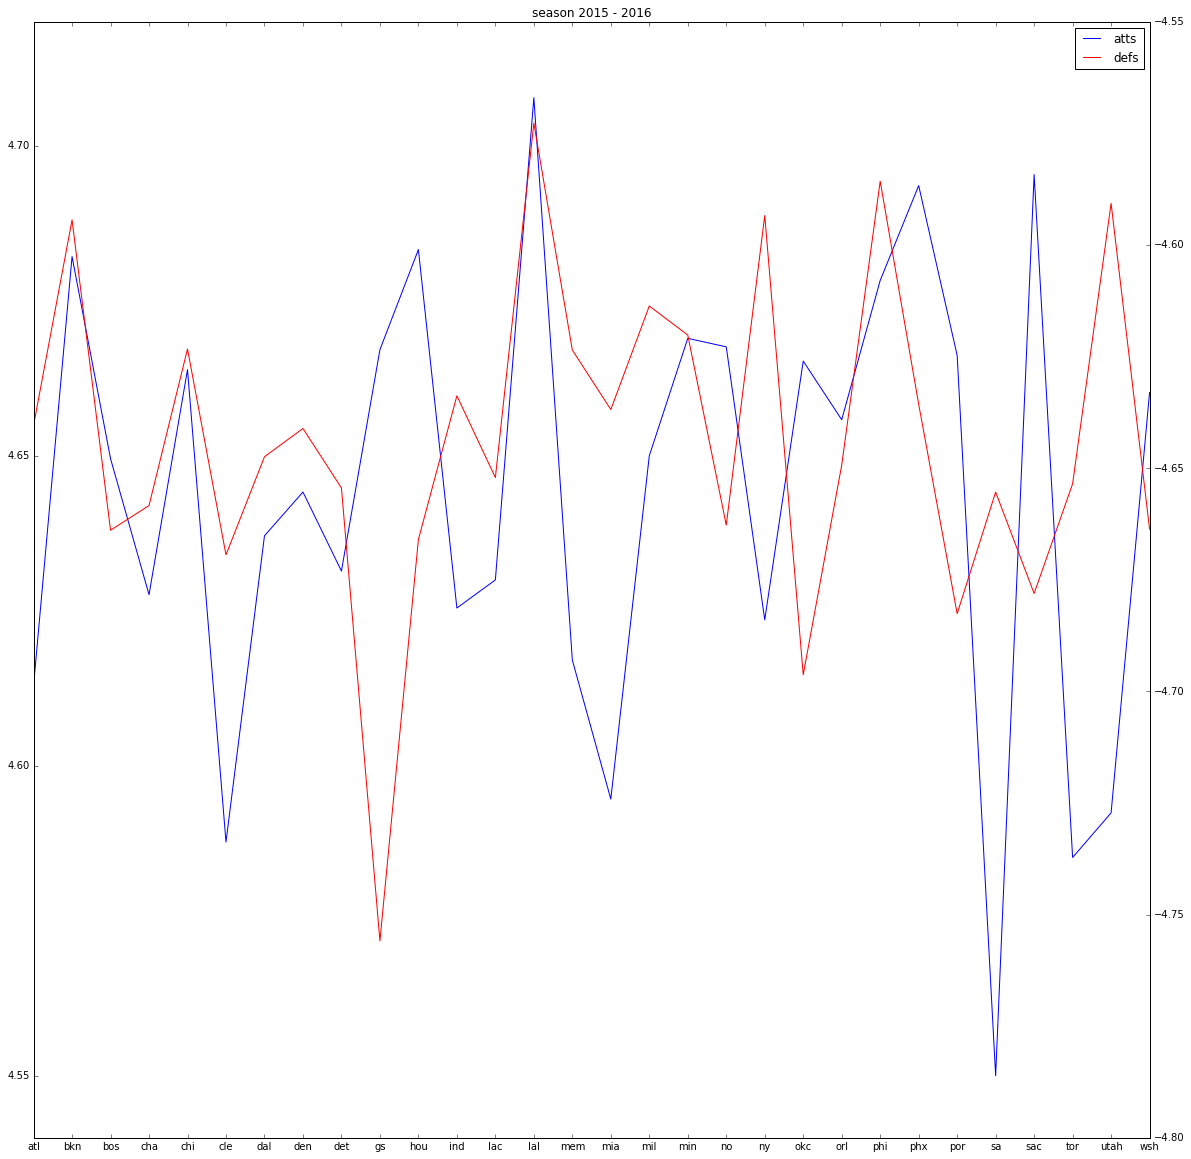

In [16]:
plt.figure(figsize=(20,20))
ax=plt.subplot(111)
ln=ax.plot(att_starting_points.values,color='blue',label='atts')
_=ax.set(xticks=np.arange(30),xticklabels=teams['team'])
ax1=ax.twinx()
ln1=ax1.plot(def_starting_points.values,color='red',label='defs')
ax1.set(title='season %s - %s' % (start_date[:4],end_date[:4]))
lns=ln + ln1
labs = [l.get_label() for l in lns]
ax.legend(lns,labs)

The model is from Deneil's blog:

$$ y_{gj} | \theta_{gj} = \text{Poisson}(\theta_{gj})$$

where the $\theta = (\theta_{g1},\theta_{g2})$ represent the scoring intensity in the g-th game for team playing at home (j=1) and away(j=2), respectively. They use a log-linear model for the thetas:
$$ log\theta_{g1} = home + att_{h(g)} + def_{a(g)} $$
$$ log\theta_{g2} = att_{a(g)} + def_{h(g)}$$
Note that they're breaking out team strength into offense and defense strength. A negative defense parameter will sap the mojo from the opposing team's offense parameter.

*home* represents home-court advantage, and in this model is assumed to be constant across teams. (In real world, we know there is home court advantage). The prior on the home and intercept parameters is flat:
$$ home \sim Normal(0,.0001) $$
$$ intercept \sim Normal(0,.0001)$$
The team-specific effect are modeled as exchangeable:
$$ att_t \sim Normal(\mu_{att}, \tau_{att})$$
$$ def_t \sim Normal(\mu_{def},\tau_{def})$$
To ensure identifiability, they impose a sum-to-zero constraint on the offense and defense parameters. They also tried a corner constraint (pinning one team's parameter to 0,0), but found that interpretation is easier in the sum-to-zero case because it's not relateive to the 0,0 team.
$$ \sum^T_{t=1} att_t = 0$$
$$ \sum^T_{t=1} def_t = 0$$
The hyper priors on the offense and defense parameters are also flat

# [Daneil's](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/) Tweaks

It didn't make sense to have a $\mu_{att}$ when we're enforcing the sum-to-zero constraint by subtracting the mean anyway.
$$ att_t \sim Normal(0,\tau_{att})$$
$$ def_t \sim Normal(0,\tau_{def})$$
Also because of the sum-to-zero constraint, it seemed to need an intercept term in the log-linear model, capturing the average scores per game by the away team:
$$ log \theta_{g1} = intercept + home + att_{h(g)} + def_{a(g)}$$
$$ log \theta_{g2} = intercept + att_{a(g)} + def_{h(g)}$$


In [17]:
###################     prepare for the model ################################
observed_home_scores = df.home_score.values
observed_away_scores = df.away_score.values
home_team = df.i_home.values;home_team=home_team.astype(np.int8)
away_team = df.i_away.values;away_team=away_team.astype(np.int8)
num_teams = len(teams['team'])
num_games = len(home_team)
##################    Model    ##############################################
#hyperpriors
home = pymc.Normal('home', 0, .0001, value=0)
tau_att = pymc.Gamma('tau_att', .1, .1, value=10)
tau_def = pymc.Gamma('tau_def', .1, .1, value=10)
intercept = pymc.Normal('intercept', 0, .0001, value=0)

#team-specific parameters
atts_star = pymc.Normal("atts_star", 
                        mu=0, 
                        tau=tau_att, 
                        size=num_teams, 
                        value=att_starting_points.values)
defs_star = pymc.Normal("defs_star", 
                        mu=0, 
                        tau=tau_def, 
                        size=num_teams, 
                        value=def_starting_points.values) 

# trick to code the sum to zero contraint
@pymc.deterministic
def atts(atts_star=atts_star):
    atts = atts_star.copy()
    atts = atts - np.mean(atts_star)
    return atts

@pymc.deterministic
def defs(defs_star=defs_star):
    defs = defs_star.copy()
    defs = defs - np.mean(defs_star)
    return defs

@pymc.deterministic
def home_theta(home_team=home_team, # index of home team
               away_team=away_team, # index of away team
               home=home, # prior home advantage
               atts=atts, # mean center offense
               defs=defs, # mean center defense
               intercept=intercept): 
    return np.exp(intercept + 
                  home + 
                  atts[home_team] + 
                  defs[away_team])
  
@pymc.deterministic
def away_theta(home_team=home_team, 
               away_team=away_team, 
               home=home, 
               atts=atts, 
               defs=defs, 
               intercept=intercept): 
    return np.exp(intercept + 
                  atts[away_team] + 
                  defs[home_team])   

home_scores = pymc.Poisson('home_scores', 
                          mu=home_theta, 
                          value=observed_home_scores, 
                          observed=True)
away_scores = pymc.Poisson('away_scores', 
                          mu=away_theta, 
                          value=observed_away_scores, 
                          observed=True)

mcmc = pymc.MCMC([home, intercept, tau_att, tau_def, 
                  home_theta, away_theta, 
                  atts_star, defs_star, atts, defs, 
                  home_scores, away_scores])
map_ = pymc.MAP( mcmc )
map_.fit()
mcmc.sample(200000, 40000, 20)

 [-----------------100%-----------------] 200000 of 200000 complete in 237.5 sec

Plotting home
Plotting intercept
Plotting tau_att
Plotting tau_def
Plotting atts_0
Plotting atts_1
Plotting atts_2
Plotting atts_3
Plotting atts_4
Plotting atts_5
Plotting atts_6
Plotting atts_7
Plotting atts_8
Plotting atts_9
Plotting atts_10
Plotting atts_11
Plotting atts_12
Plotting atts_13
Plotting atts_14
Plotting atts_15
Plotting atts_16
Plotting atts_17
Plotting atts_18
Plotting atts_19
Plotting atts_20
Plotting atts_21
Plotting atts_22
Plotting atts_23
Plotting atts_24
Plotting atts_25
Plotting atts_26
Plotting atts_27
Plotting atts_28
Plotting atts_29
Plotting defs_0
Plotting defs_1
Plotting defs_2
Plotting defs_3
Plotting defs_4
Plotting defs_5
Plotting defs_6
Plotting defs_7
Plotting defs_8
Plotting defs_9
Plotting defs_10
Plotting defs_11
Plotting defs_12
Plotting defs_13
Plotting defs_14
Plotting defs_15
Plotting defs_16
Plotting defs_17
Plotting defs_18
Plotting defs_19
Plotting defs_20
Plotting defs_21
Plotting defs_22
Plotting defs_23
Plotting defs_24
Plotting defs_25
P

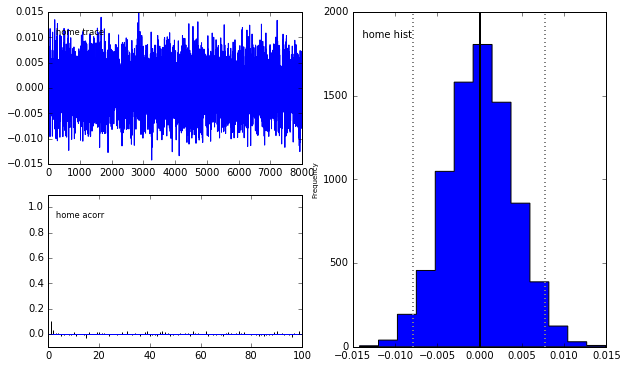

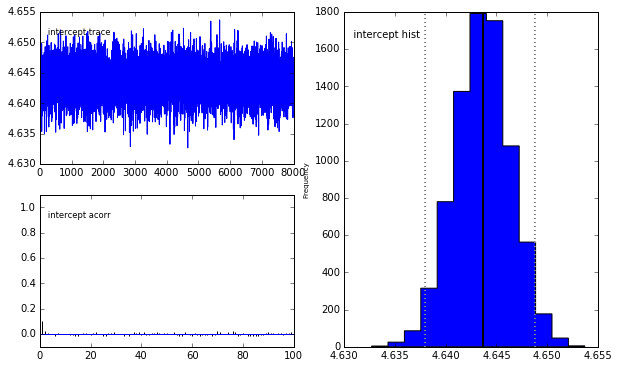

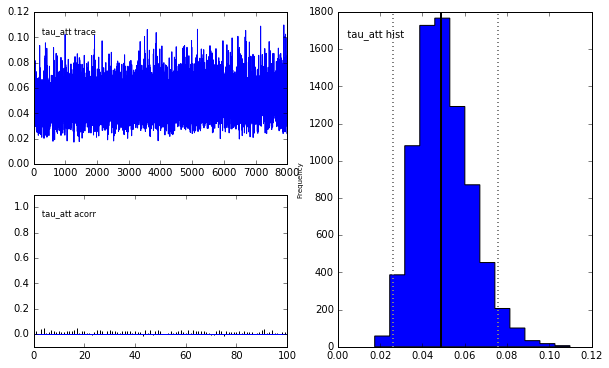

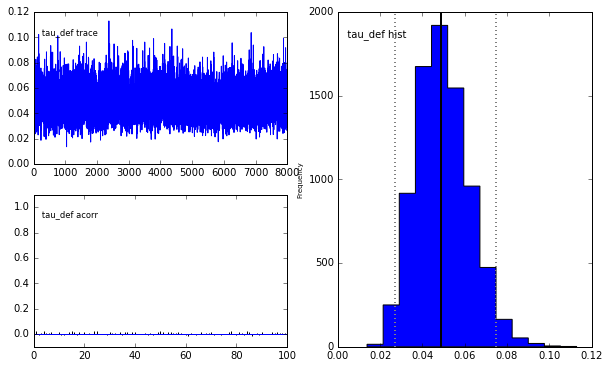

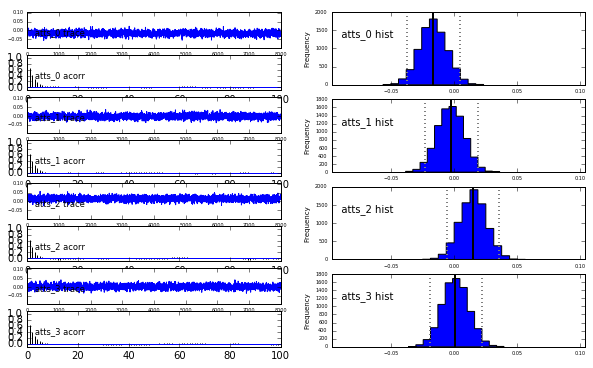

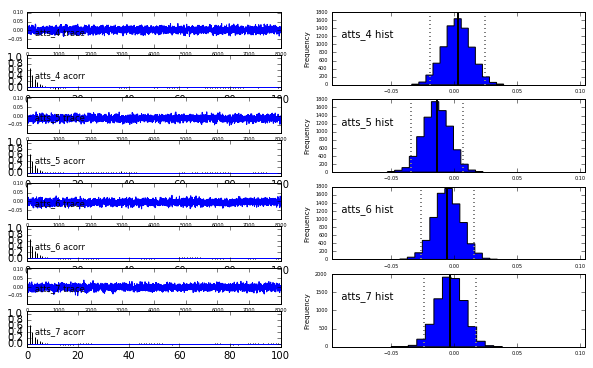

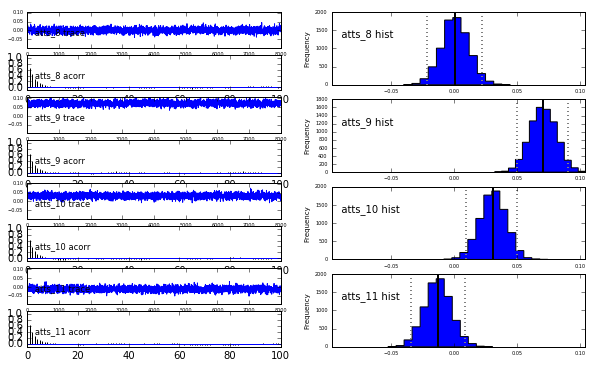

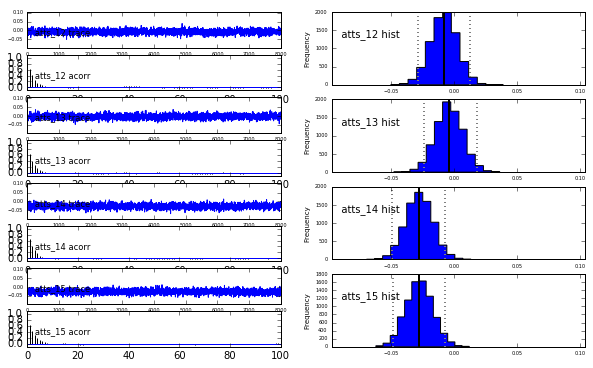

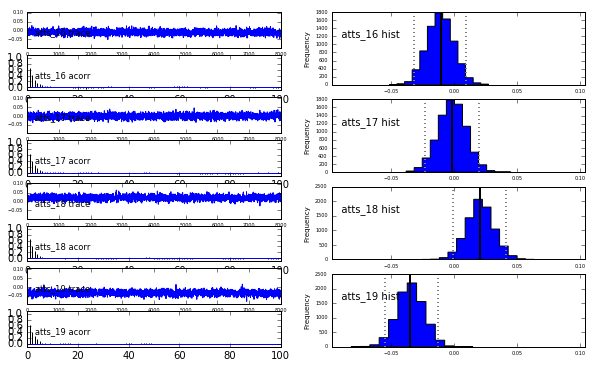

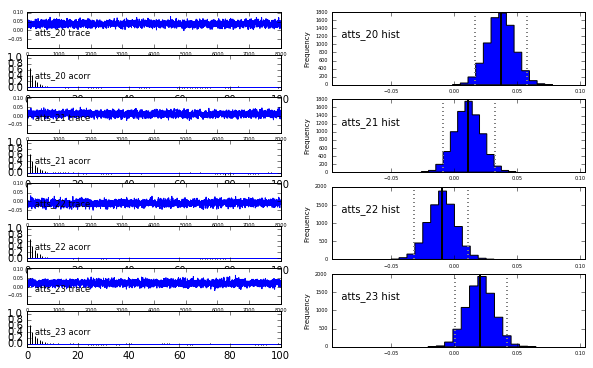

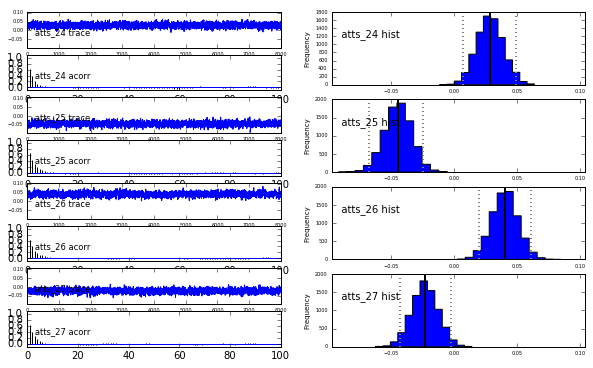

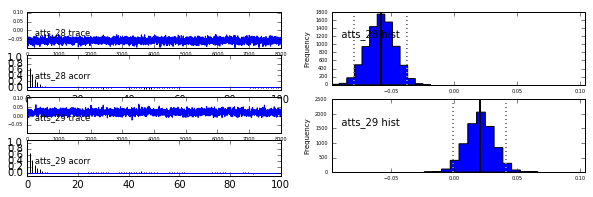

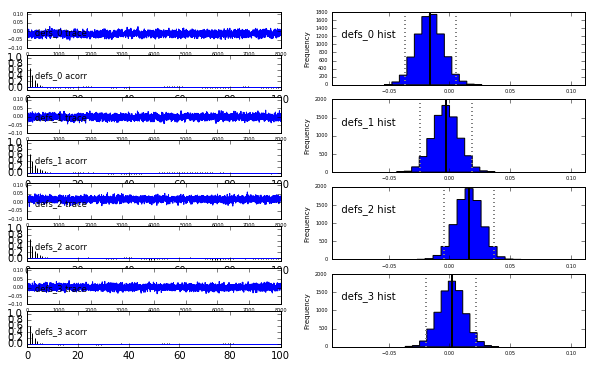

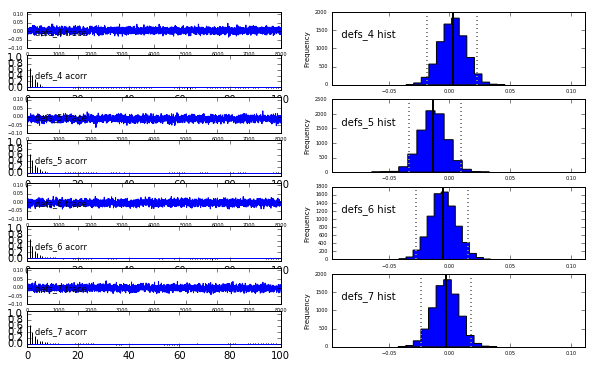

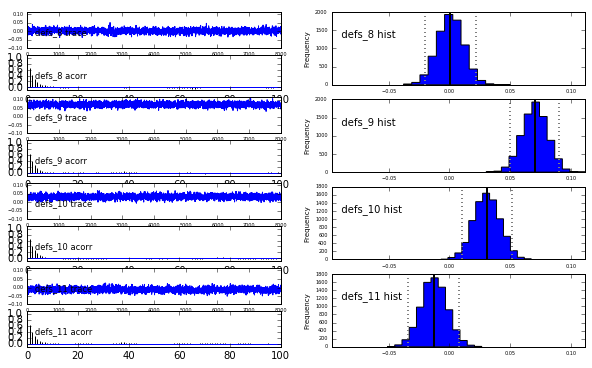

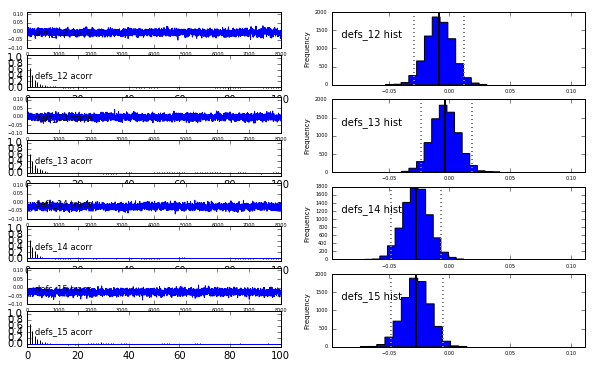

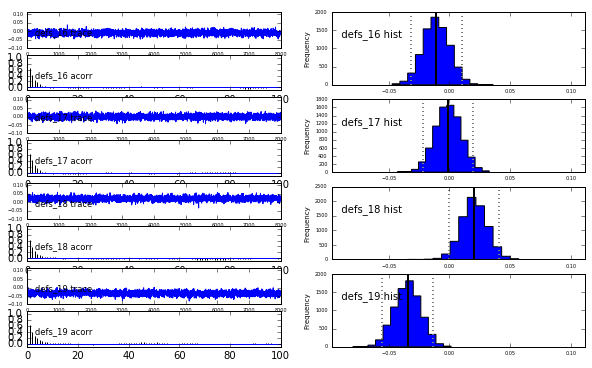

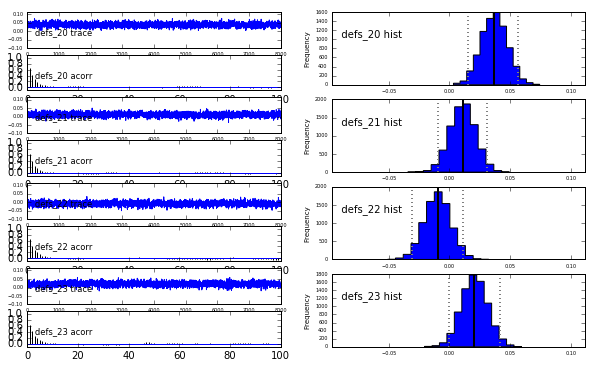

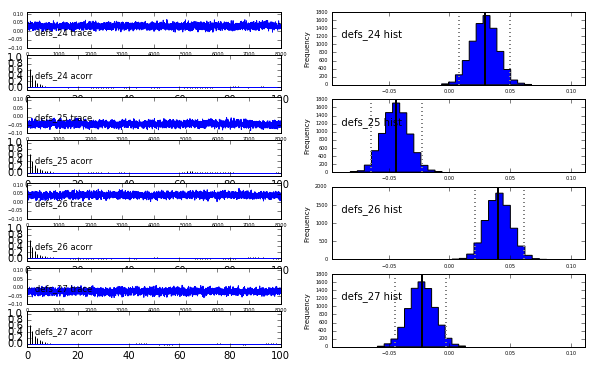

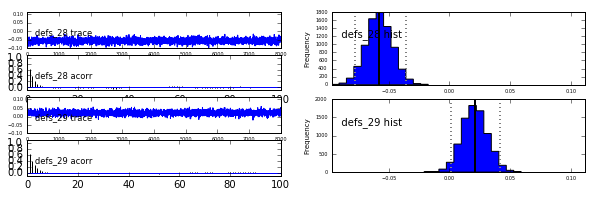

In [18]:
pymc.Matplot.plot(home)

pymc.Matplot.plot(intercept)

pymc.Matplot.plot(tau_att)
pymc.Matplot.plot(tau_def)

pymc.Matplot.plot(atts)
pymc.Matplot.plot(defs)

# Visualizing offense posteriors
6 teams were doing better than zero: Golden State, Sacramento, OKC, Houston, Portland, and Pheonix, among which Houston and Sacramento are big surprises. And 6 teams are struggling in offense: Utah, San Antonio, New York Knicks, Memphis, Miami, and Toronto. They are no surprises. 

c:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


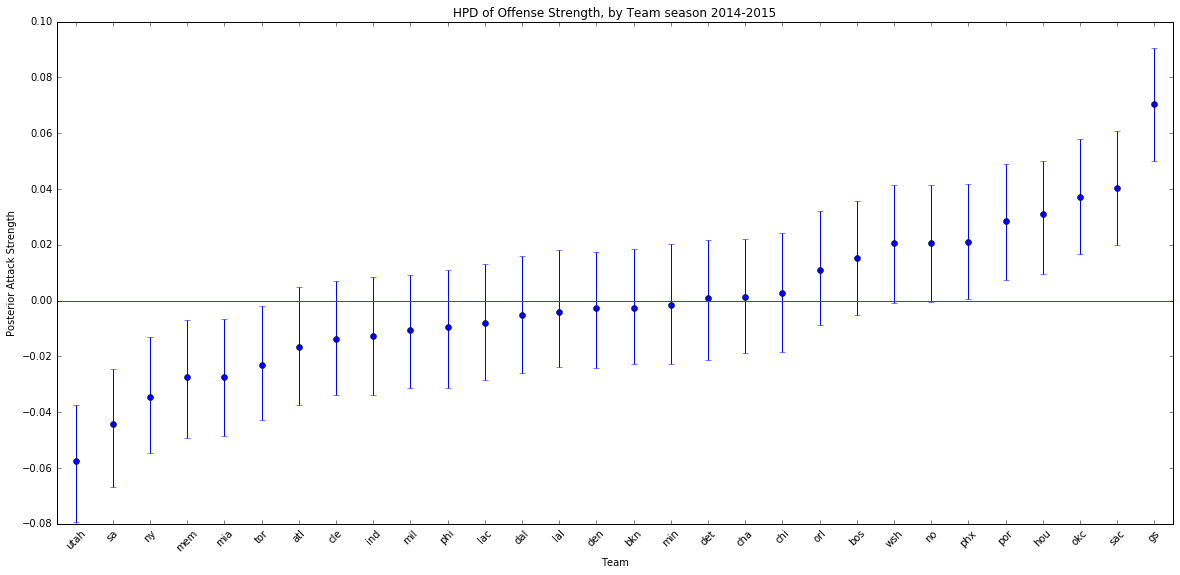

In [19]:
df_hpd = pd.DataFrame(atts.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(atts.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(20,9))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.axhline(0,color='r')
_=axs.set(title='HPD of Offense Strength, by Team season 2014-2015',xlabel='Team',ylabel='Posterior Attack Strength',
        xticks=(df_hpd.index + .5))
_=axs.set_xticklabels(df_hpd['index'].values,rotation=45)

# Visualizing defense
Seemingly one of best defensive teams, Golden State was the worse defensive team in season 2015-2016 in terms of points allowed. It is surprised that 5 of 6 worst defensive teams made the playoffs.

c:\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


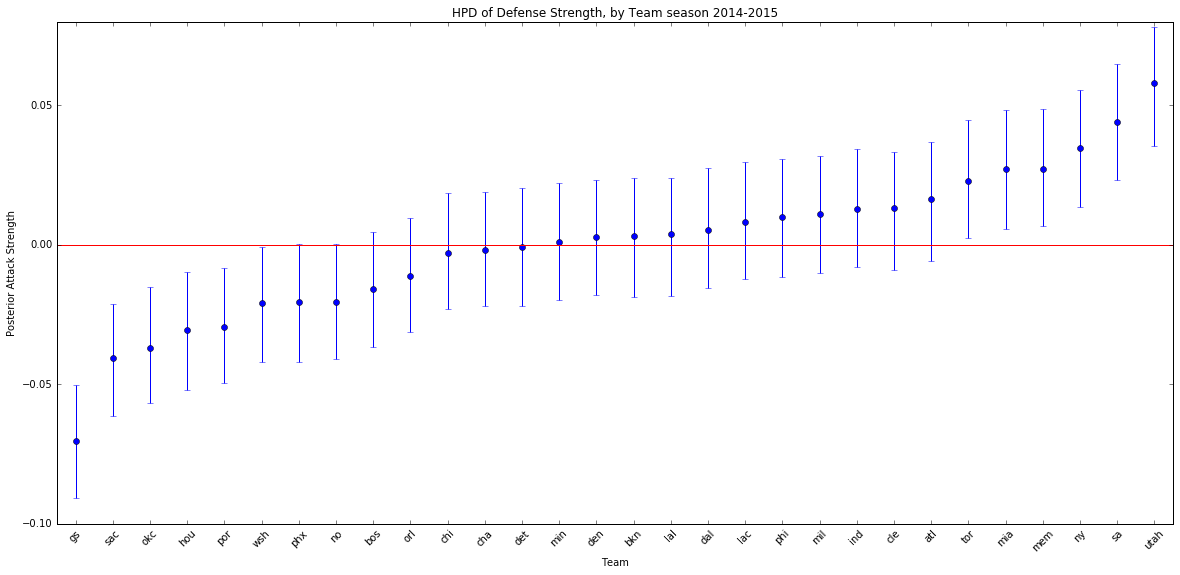

In [20]:
df_hpd = pd.DataFrame(-defs.stats()['95% HPD interval'].T, 
                      columns=['hpd_low', 'hpd_high'], 
                      index=teams.team.values)
df_median = pd.DataFrame(-defs.stats()['quantiles'][50], 
                         columns=['hpd_median'], 
                         index=teams.team.values)
df_hpd = df_hpd.join(df_median)
df_hpd['relative_lower'] = df_hpd.hpd_median - df_hpd.hpd_low
df_hpd['relative_upper'] = df_hpd.hpd_high - df_hpd.hpd_median
df_hpd = df_hpd.sort_index(by='hpd_median')
df_hpd = df_hpd.reset_index()
df_hpd['x'] = df_hpd.index + .5


fig, axs = plt.subplots(figsize=(20,9))
axs.errorbar(df_hpd.x, df_hpd.hpd_median, 
             yerr=(df_hpd[['relative_lower', 'relative_upper']].values).T, 
             fmt='o')
axs.axhline(0,color='r')
_=axs.set(title='HPD of Defense Strength, by Team season 2014-2015',xlabel='Team',ylabel='Posterior Attack Strength',
        xticks=(df_hpd.index + .5))
_=axs.set_xticklabels(df_hpd['index'].values,rotation=45)

# Simulations

We can take draws from the posterior distributions of the parameters, and simulate a season or many season. As I said, many things happened in the summer, the simulation has no predictive value. And it turns out, single attribution in basketball predicts nothing. 

In [21]:
def simulate_season():
    """
    Simulate a season once, using one random draw from the mcmc chain. 
    """
    num_samples = atts.trace().shape[0]
    draw = np.random.randint(0, num_samples)
    atts_draw = pd.DataFrame({'att': atts.trace()[draw, :],})
    defs_draw = pd.DataFrame({'def': defs.trace()[draw, :],})
    home_draw = home.trace()[draw]
    intercept_draw = intercept.trace()[draw]
    season = df.copy()
    season = pd.merge(season, atts_draw, left_on='i_home', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_home', right_index=True)
    season = season.rename(columns = {'att': 'att_home', 'def': 'def_home'})
    season = pd.merge(season, atts_draw, left_on='i_away', right_index=True)
    season = pd.merge(season, defs_draw, left_on='i_away', right_index=True)
    season = season.rename(columns = {'att': 'att_away', 'def': 'def_away'})
    season['home'] = home_draw
    season['intercept'] = intercept_draw
    season['home_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['home'] + 
                                                           x['att_home'] + 
                                                           x['def_away']), axis=1)
    season['away_theta'] = season.apply(lambda x: math.exp(x['intercept'] + 
                                                           x['att_away'] + 
                                                           x['def_home']), axis=1)
    season['home_scores'] = season.apply(lambda x: np.random.poisson(x['home_theta']), axis=1)
    season['away_scores'] = season.apply(lambda x: np.random.poisson(x['away_theta']), axis=1)
    season['home_outcome'] = season.apply(lambda x: 'win' if x['home_scores'] > x['away_scores'] else 
                                                    'loss' if x['home_scores'] < x['away_scores'] else 'draw', axis=1)
    season['away_outcome'] = season.apply(lambda x: 'win' if x['home_scores'] < x['away_scores'] else 
                                                    'loss' if x['home_scores'] > x['away_scores'] else 'draw', axis=1)
    season = season.join(pd.get_dummies(season.home_outcome, prefix='home'))
    season = season.join(pd.get_dummies(season.away_outcome, prefix='away'))
    return season


def create_season_table(season):
    """
    Using a season dataframe output by simulate_season(), create a summary dataframe with wins, losses, goals for, etc.
    
    """
    g = season.groupby('i_home')    
    home = pd.DataFrame({'home_scores': g.home_scores.sum(),
                         'home_scores_against': g.away_scores.sum(),
                         'home_wins': g.home_win.sum(),
                         'home_draws': g.home_draw.sum(),
                         'home_losses': g.home_loss.sum()
                         })
    g = season.groupby('i_away')    
    away = pd.DataFrame({'away_scores': g.away_scores.sum(),
                         'away_scores_against': g.home_scores.sum(),
                         'away_wins': g.away_win.sum(),
                         'away_draws': g.away_draw.sum(),
                         'away_losses': g.away_loss.sum()
                         })
    df = home.join(away)
    df['wins'] = df.home_wins + df.away_wins
    df['draws'] = df.home_draws + df.away_draws
    df['losses'] = df.home_losses + df.away_losses
    df['points'] = df.wins + df.draws
    df['gf'] = (df.home_scores + df.away_scores)/82
    df['ga'] = (df.home_scores_against + df.away_scores_against)/82
    df['gd'] = df.gf - df.ga
    df = pd.merge(teams, df, left_on='i', right_index=True)
    df = df.sort_index(by='points', ascending=False)
    df = df.reset_index()
    df['position'] = df.index + 1
    df['champion'] = (df.position == 1).astype(int)
    df['qualified_for_final_4'] = (df.position < 4).astype(int)
    df['playoffs'] = (df.position < 16).astype(int)
    return df  
    
def simulate_seasons(n=100):
    dfs = []
    for i in range(n):
        s = simulate_season()
        t = create_season_table(s)
        t['iteration'] = i
        dfs.append(t)
    return pd.concat(dfs, ignore_index=True)

In [22]:
simuls = simulate_seasons(100)

c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:66: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


In [23]:
def plot_simulation(simulation,team, attribution='wins',start_date=start_date,end_date=end_date):
    ax = simulation[attribution][simulation['team']==team].hist(figsize=(7,5))
    ax.set(title='%s: %s - %s %s, 1000 simulations'%(team, start_date[:4],end_date[:4],attribution))
    ax.axvline(simulation[attribution][simulation['team']==team].mean())
    stats=simulation[attribution][simulation['team']==team].mean()
    _=plt.annotate('Mean: %d' % stats, xy=(stats+1,ax.get_ylim()[1]-10))
    return ax

# Spurs...my spurs
The simulation predicts the Spurs will have a around 50% winning percentage, which could or could not happen. After I look at all the teams, it's just a lousy model. 

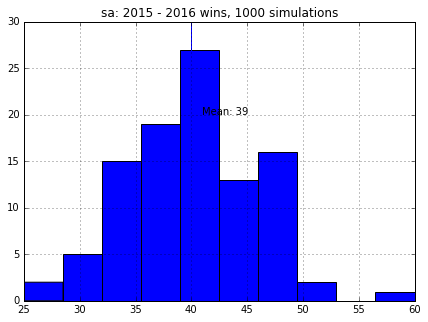

In [24]:
plot_simulation(simuls,'sa','wins')

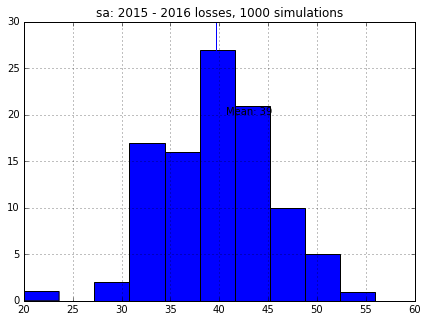

In [25]:
plot_simulation(simuls,'sa','losses')

c:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


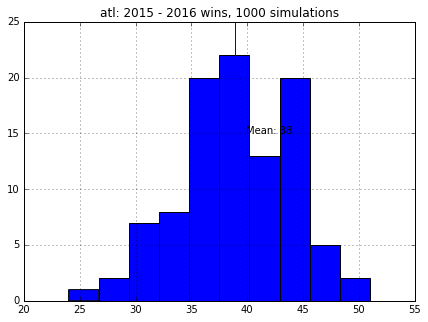

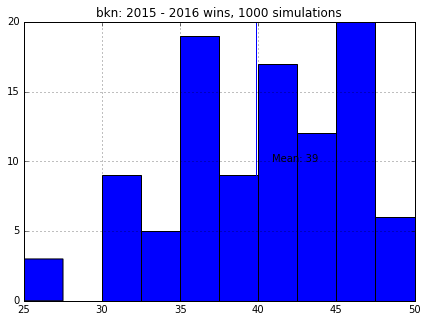

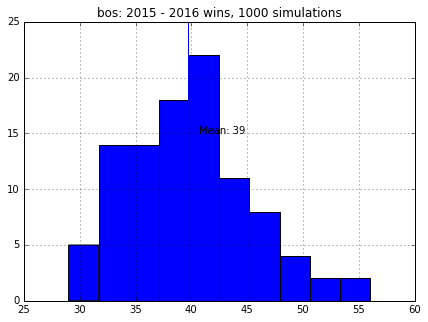

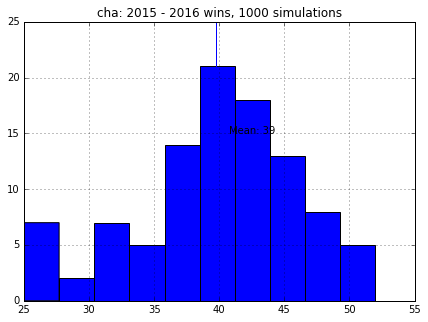

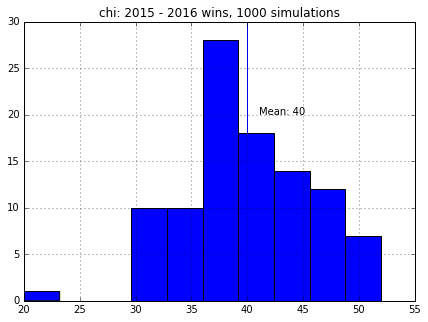

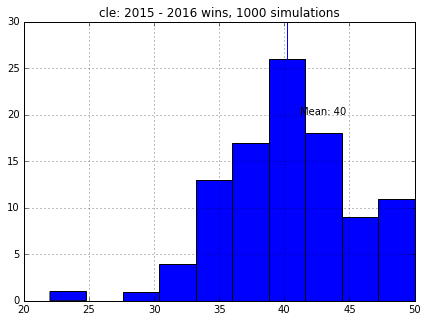

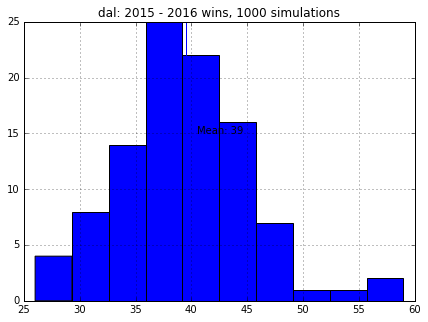

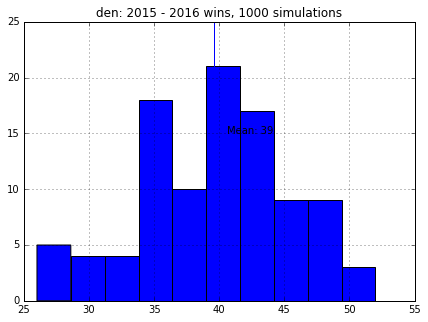

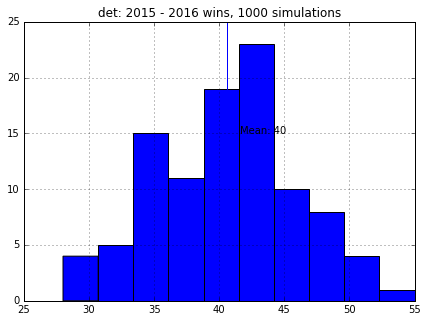

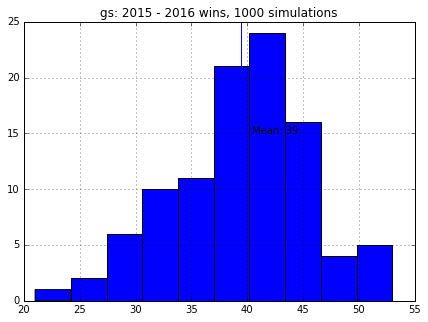

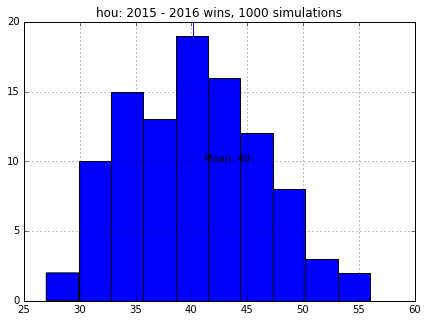

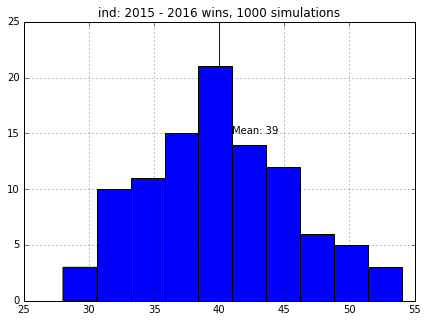

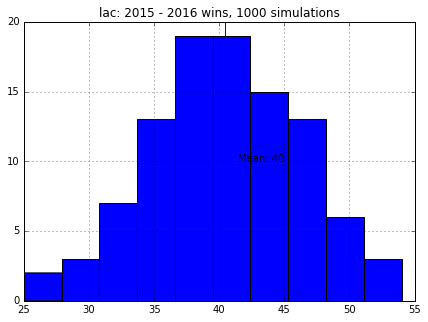

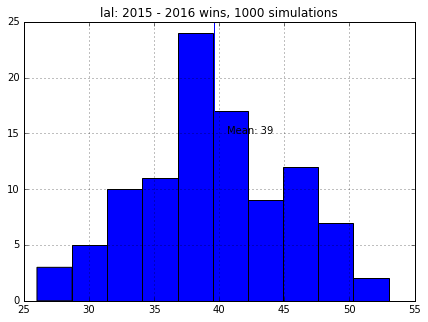

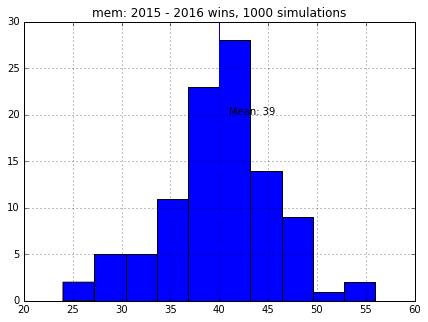

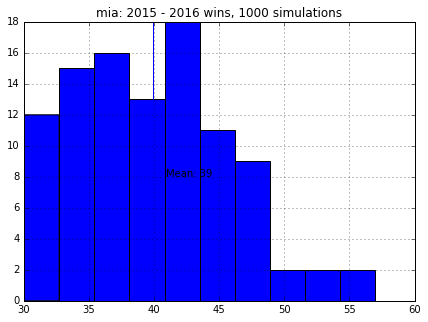

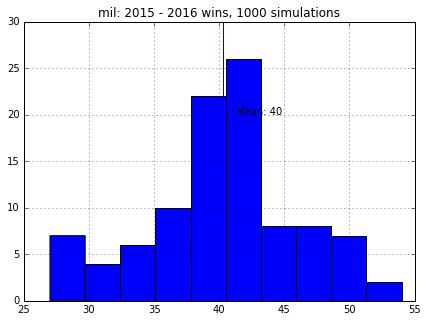

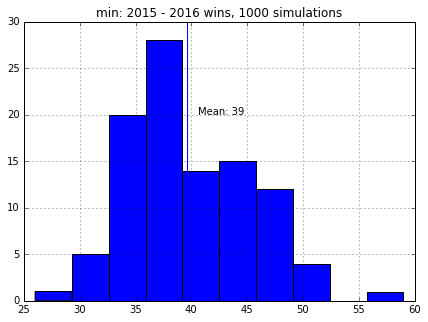

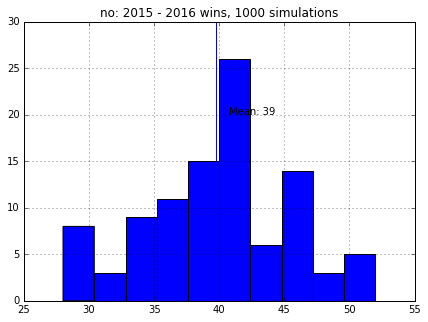

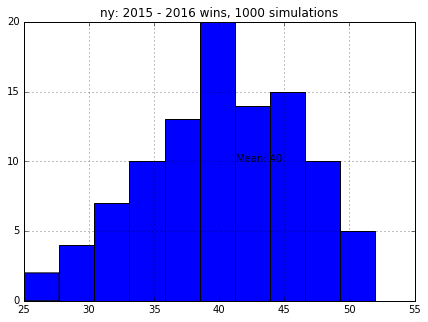

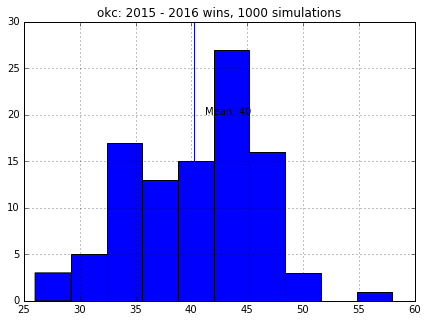

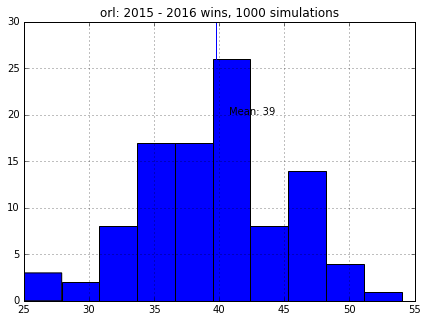

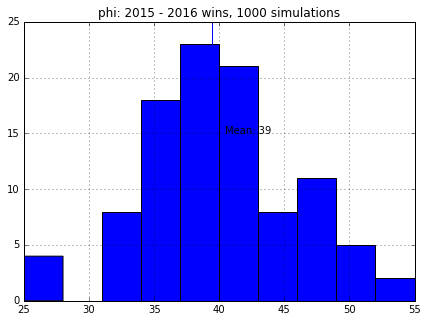

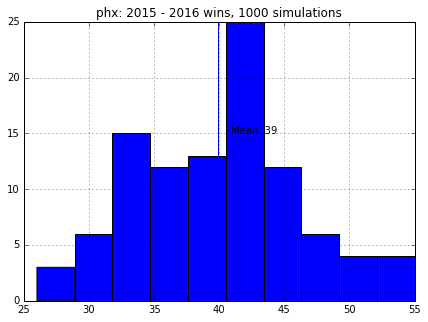

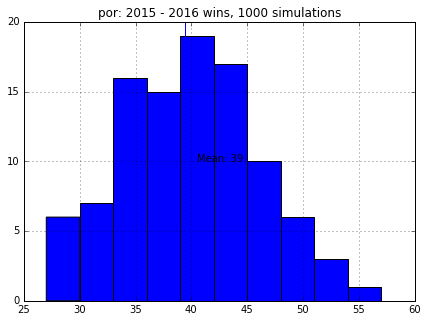

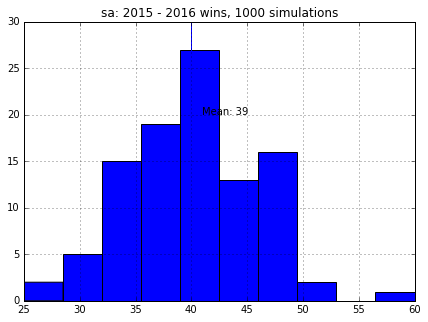

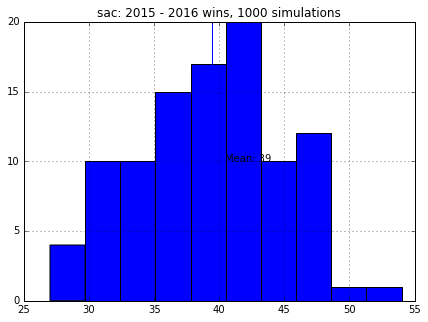

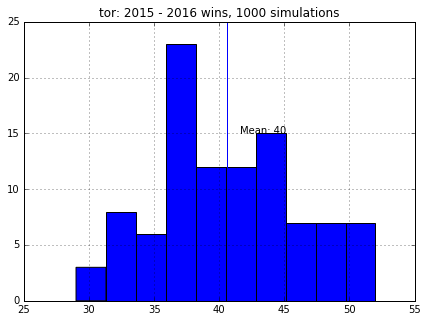

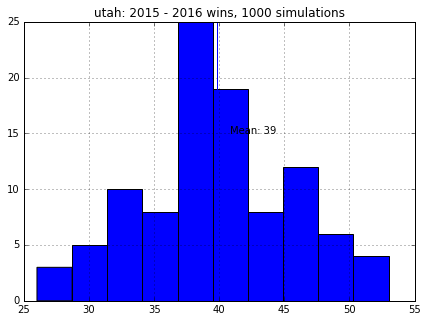

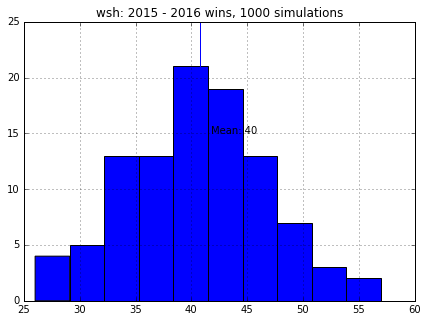

In [26]:
for name in teams['team']:
    plt.figure()
    plot_simulation(simuls,name,'wins')

# This is interesting...
Charlotte becomes the most average team in terms of getting in the playoffs. The prediction seems good to me because most of them match to my heuristic predictions. 

c:\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


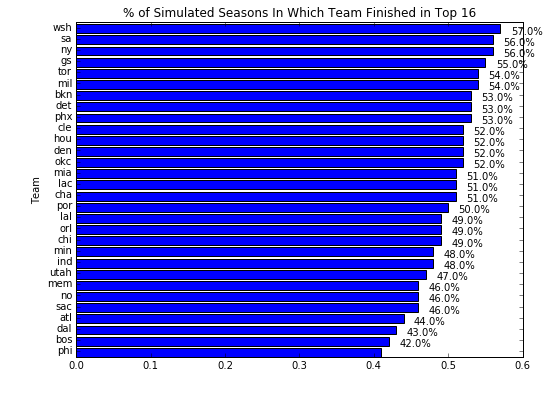

In [27]:
g = simuls.groupby('team')
df_champs = pd.DataFrame({'percent_champs': g.champion.mean(),
                          'percent_playoffs': g.playoffs.mean()})
df_champs = df_champs.sort_index(by='percent_playoffs')
df_champs = df_champs[df_champs.percent_playoffs > .05]
df_champs = df_champs.reset_index()

fig, ax = plt.subplots(figsize=(8,6))
ax.barh(df_champs.index.values, df_champs.percent_playoffs.values)

for i, row in df_champs.iterrows():
    label = "{0:.1f}%".format(100 * row['percent_playoffs'])
    ax.annotate(label, xy=(row['percent_playoffs']+.01, i-1), xytext = (3, 10), textcoords = 'offset points')
ax.set_ylabel('Team')
ax.set_title('% of Simulated Seasons In Which Team Finished in Top 16')
_= ax.set_yticks(df_champs.index + .5)
_= ax.set_yticklabels(df_champs['team'].values)